In [1]:
import os
import numpy as np
import pandas as pd
import tqdm
import multiprocessing

## Load CSV


In [2]:
all_data_filename = r'D:\github_repo_forked\lifetime_value\gravity_data\gravity_user_data_offline_2471_25126.csv'
all_df = pd.read_csv(all_data_filename)
all_df['app_id'].unique()

C:\Users\jingyuan.hao\AppData\Local\Temp\ipykernel_2532\3814317187.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  all_df = pd.read_csv(all_data_filename)


array([20569324, 22513480, 22695317, 24703865, 23274508, 21257968,
       26924137, 20386579, 25861704, 21039845, 23246518, 26983102,
       24752109, 26329175, 21436295, 26517342, 24612985, 25906712,
       22735061, 26102874, 24186950, 28503912, 23056127, 27024591,
       25826917, 27268594, 23652817, 28360524, 21095368, 20695487,
       27963825, 21457389, 24659730, 26059384, 24819273, 24392865,
       24619237, 28704162, 28139057, 24726895, 28624371, 27890145,
       23752106, 22581793, 24619308])

In [7]:
app_counts = all_df['app_id'].value_counts()
large_apps = app_counts[app_counts > 10000].index.tolist()

print("App IDs with >10000 records:", large_apps)
print(f"Number of large apps: {len(large_apps)}")

App IDs with >10000 records: [24619237, 24392865, 23652817, 21257968, 26102874, 26983102, 24659730, 28503912, 27024591, 22513480, 24703865, 26517342]
Number of large apps: 12


In [8]:
app_ids= [24619237, 24392865, 23652817, 21257968, 26102874, 26983102, 24659730, 28503912, 27024591, 22513480, 24703865, 26517342]

In [7]:
app_id_list_from_event = [
    24612985,
    25906712,
    22695317,
    26924137,
    26329175,
    23246518,
    24819273,
    23274508,
    24619308,
    21457389,
    28624371,
    23752106,
    22735061,
    21039845,
    26059384,
    27268594,
    21095368,
    28139057,
    24752109,
    24186950,
    22581793,
    21436295,
    20386579,
    20569324,
    27890145
]

In [8]:
app_from_event_counts_dict = {}
app_counts = all_df['app_id'].value_counts()
for app in app_id_list_from_event:
    print(app, app_counts[app])
    app_from_event_counts_dict[app] = app_counts[app]
sorted_app_from_event_counts = sorted(app_from_event_counts_dict.items(), key=lambda x: x[1], reverse=True)
print(sorted_app_from_event_counts)

24612985 2672
25906712 945
22695317 132
26924137 304
26329175 3
23246518 277
24819273 195
23274508 1
24619308 5
21457389 50
28624371 6
23752106 1
22735061 2
21039845 107
26059384 319
27268594 94
21095368 467
28139057 1909
24752109 53
24186950 4
22581793 14
21436295 1353
20386579 486
20569324 4
27890145 15
[(24612985, np.int64(2672)), (28139057, np.int64(1909)), (21436295, np.int64(1353)), (25906712, np.int64(945)), (20386579, np.int64(486)), (21095368, np.int64(467)), (26059384, np.int64(319)), (26924137, np.int64(304)), (23246518, np.int64(277)), (24819273, np.int64(195)), (22695317, np.int64(132)), (21039845, np.int64(107)), (27268594, np.int64(94)), (24752109, np.int64(53)), (21457389, np.int64(50)), (27890145, np.int64(15)), (22581793, np.int64(14)), (28624371, np.int64(6)), (24619308, np.int64(5)), (24186950, np.int64(4)), (20569324, np.int64(4)), (26329175, np.int64(3)), (22735061, np.int64(2)), (23274508, np.int64(1)), (23752106, np.int64(1))]


## 预处理数据

### 创建label：adltv+payment>0

In [14]:
# Create label based on combined value
all_df['total_value'] = all_df['user$ad_ltv'].fillna(0) + all_df['user$pay_amount_sum'].fillna(0)
all_df['label'] = (all_df['total_value'] > 0).astype(int)

# Verify label distribution
print("Label distribution:")
print(all_df['label'].value_counts(normalize=True))
print("\nTotal samples:", len(all_df))
print("Valuable customers (label=1):", all_df['label'].sum())
print("Non-valuable customers (label=0):", len(all_df) - all_df['label'].sum())

# Drop intermediate column if not needed
all_df.drop('total_value', axis=1, inplace=True)

Label distribution:
label
0    0.688572
1    0.311428
Name: proportion, dtype: float64

Total samples: 471965
Valuable customers (label=1): 146983
Non-valuable customers (label=0): 324982


### 删除多余的列

In [15]:
# Define features to keep
base_features = [
    'AdPlatform', 
    'Channel',
    'Version',
    'user$brand',
    'user$city',
    'user$country',
    'user$model',
    'user$os',
    'app_id',
    'ClientID'
]

label_features = [
    # 'user$ad_ltv',
    # 'user$pay_amount_sum',
    'label'
]

# Keep only selected features
features_to_keep = base_features + label_features
all_cols = all_df.columns.tolist()
cols_to_drop = [col for col in all_cols if col not in features_to_keep]
all_df.drop(columns=cols_to_drop, inplace=True)

# Verify remaining columns
print("Remaining columns:", all_df.columns.tolist())
print("Shape after dropping:", all_df.shape)

Remaining columns: ['ClientID', 'AdPlatform', 'Channel', 'Version', 'user$brand', 'user$city', 'user$country', 'user$model', 'user$os', 'app_id', 'label']
Shape after dropping: (471965, 11)


### 处理缺省值

In [16]:
object_cols = all_df.select_dtypes(include=['object']).columns
object_cols

Index(['ClientID', 'AdPlatform', 'Channel', 'user$brand', 'user$city',
       'user$country', 'user$model', 'user$os'],
      dtype='object')

In [17]:
# Define columns to process
cols_to_process =object_cols

# Replace nan with '0' in specified columns
all_df[cols_to_process] = all_df[cols_to_process].fillna('0')

# Verify changes
for col in cols_to_process:
    print(f"\n{col} unique values after replacement:")
    print(all_df[col].value_counts().head())
    print(f"Null values in {col}: {all_df[col].isnull().sum()}")


ClientID unique values after replacement:
ClientID
812477A5F873444AB5463A6F1B8D4D7Ad7f40217284ca2d5f2a313a70b6e4d46    17
6237bad0a036902372576b8be8c2c1bb2e9539e723216d4c1908afccdf8d2ec1    16
a16a1d9defb86bef                                                    16
0f641e019ccd572a3918c32eae22cdefb6f036af121da3393c753da3b301df3b    16
00000000-0000-0000-0000-000000000000                                14
Name: count, dtype: int64
Null values in ClientID: 0

AdPlatform unique values after replacement:
AdPlatform
0            272738
bytedance    196148
tencent        1809
taptap         1270
Name: count, dtype: int64
Null values in AdPlatform: 0

Channel unique values after replacement:
Channel
base_channel    316294
official         69133
taptap           51692
3839             18832
appstore         12317
Name: count, dtype: int64
Null values in Channel: 0

user$brand unique values after replacement:
user$brand
HUAWEI    83056
HONOR     65817
OPPO      58151
APPLE     51186
VIVO      47

### 保存每一列的unique值

In [54]:
# Create output file and write unique values for each object column
object_cols = all_df.select_dtypes(include=['object']).columns

with open('unique_values.txt', 'w', encoding='utf-8') as f:
    for col in object_cols:
        if col == 'ClientID':
            continue
        f.write(f"\n{col}\n")
        f.write("="*50 + "\n")
        unique_vals = all_df[col].unique()
        f.write(f"Count of unique values: {len(unique_vals)}\n")
        f.write("Values:\n")
        for val in unique_vals:
            f.write(f"{val}\n")
        f.write("-"*50 + "\n")

print("Unique values written to unique_values.txt")

Unique values written to unique_values.txt


### 保存清洗后的总数据

In [18]:
all_df.to_csv(r'D:\github_repo_forked\lifetime_value\gravity_data\cleaned_data.csv', index=False)

### 按游戏进行数据区分

In [27]:
def load_data(appid,rewrite=False):
  all_data_filename = r'D:\github_repo_forked\lifetime_value\gravity_data\cleaned_data.csv'
  one_app_data_filename = (
      r'D:\github_repo_forked\lifetime_value\gravity_data\transactions_app_{}.csv'
      .format(appid))
  
  if os.path.isfile(one_app_data_filename):
    if rewrite == False:
      df = pd.read_csv(one_app_data_filename)
      return df

  data_list = []
  chunksize = 10**6
  # 350 iterations
  for chunk in tqdm.tqdm(pd.read_csv(all_data_filename, chunksize=chunksize)):
    data_list.append(chunk.query("app_id=={}".format(appid)))
  df = pd.concat(data_list, axis=0)
  df.to_csv(one_app_data_filename, index=None)
  return df

In [15]:
for appid in app_ids:
  df = load_data(str(appid))
  print(f"App ID: {appid}, Number of records: {len(df)}")

1it [00:00,  1.95it/s]


App ID: 24619237, Number of records: 97500


1it [00:00,  1.76it/s]


App ID: 24392865, Number of records: 76169


1it [00:00,  1.97it/s]


App ID: 23652817, Number of records: 58600


1it [00:00,  1.88it/s]


App ID: 21257968, Number of records: 48646


1it [00:00,  1.97it/s]


App ID: 26102874, Number of records: 44814


1it [00:00,  1.84it/s]


App ID: 26983102, Number of records: 22972


1it [00:00,  1.91it/s]


App ID: 24659730, Number of records: 17430


1it [00:00,  2.02it/s]


App ID: 28503912, Number of records: 16113


1it [00:00,  1.95it/s]


App ID: 27024591, Number of records: 13875


1it [00:00,  2.00it/s]


App ID: 22513480, Number of records: 13504


1it [00:00,  1.72it/s]


App ID: 24703865, Number of records: 12314


1it [00:00,  1.98it/s]

App ID: 26517342, Number of records: 11228


In [28]:
d = load_data(str(24612985),True)
print(f"App ID: {24612985}, Number of records: {len(d)}")

1it [00:00,  1.19it/s]

App ID: 24612985, Number of records: 2672


In [29]:
df985 = pd.read_csv(r'D:\github_repo_forked\lifetime_value\gravity_data\transactions_app_24612985.csv')
print("Label distribution:")
print(df985['label'].value_counts(normalize=True))
print("\nTotal samples:", len(df985))
print("Valuable customers (label=1):", df985['label'].sum())
print("Non-valuable customers (label=0):", len(df985) - df985['label'].sum())

Label distribution:
label
0    1.0
Name: proportion, dtype: float64

Total samples: 2672
Valuable customers (label=1): 0
Non-valuable customers (label=0): 2672


In [30]:
df985.head()

,ClientID,AdPlatform,Channel,Version,user$brand,user$city,user$country,user$model,user$os,app_id,label
0,_000TGX_GpQOiL-lVjG-9x0du9JSHCgKjXi6,0,base_channel,1,APPLE,上海市,中国,Apple,ios,24612985,0
1,_000k-aMpnwR3Ff465E7HdKGlRd4rvv_DBre,0,base_channel,1,HUAWEI,本溪,中国,HUAWEI,android,24612985,0
2,_0002bDdlKXrg20rcV9Bbb_TgWqaIJa7cWiz,0,base_channel,1,XIAOMI,拉萨市,中国,Xiaomi,android,24612985,0
3,_000r5WSVomolKv4SsED9eaKiRlylQ29Qmws,0,base_channel,1,VIVO,合肥市,中国,vivo,android,24612985,0
4,_000-vKYOUMdtC4EtYU_bs9hhwgWKpoVItt2,0,base_channel,1,VIVO,乌鲁木齐市,中国,vivo,android,24612985,0


In [31]:
df985event = pd.read_csv(r'D:\github_repo_forked\lifetime_value\gravity_data\985event.csv')

In [32]:
df985event.head()

,UUID,event_name,app_id,client_id,ad_id,trigger_count,trigger_date
0,00002308-0b03-4011-b3f1-426cfef9275c,小程序启动.总次数,24612985,_0009XY12nETIiLg7X3CcsnUFht8X22SZtge,NaN,0,8/1/2025 00:00:00
1,000068ea-9b24-4c33-b0ea-cdd2acd7648a,小程序进入后台.总次数,24612985,_000Vxh7tx3hp5lqzbLKHy3MRWAtek3uVTG-,NaN,0,8/12/2024 00:00:00
2,00009be8-6d4c-4cc0-90a1-959b1cde4f6d,小程序用户注册.总次数,24612985,_0003CCuAOJvq5D6cFomgivzWKrpyXRs6bXm,NaN,0,18/11/2024 00:00:00
3,00013bfc-ce1a-4bde-bf4d-832f5320cd50,小程序启动.总次数,24612985,_000-jRIOCT-Du2oV5wYHmarSMcRaj1605NZ,NaN,0,12/12/2024 00:00:00
4,0005eaed-074b-4eb7-b10c-31777c639638,小程序启动.总次数,24612985,_0008fXaX0kOQe2dOhmG0T908fSspjDsbqL7,NaN,0,17/1/2025 00:00:00


In [36]:
df985event['client_id'].value_counts()

client_id
_000tDwjq1I4-RPBEQ3JxNLLbjV_YwH8jXcu    595
_000UH_QtrmSH3sTvoGrOgD5522Hr9Lms88C    595
_000OrSJtU141bVfgP_cFYYZyPPg9IvZZfCv    595
_000FdghHoLzzCdjzBxCK8Z6KJzkeY-JDk0w    595
_0002tHH1hN_uwAbzxKObQnttsZs-4V_do7c    595
                                       ... 
_000EdamABkMflHnrUTBSUdigVWDLtY3Akk1    238
_0009R-UWpWg8Q4rmjF1il5VDzR7tOqqqZC9    238
_000IM-l9G8QIaBEF-l2NBBhJIgN_ejhgkPL    119
_000AfnJruqBUpZD99xBfpFgl3L3jUfWGHHX    119
_000ExsAZCCXGUu8thod9sZNf5ZMB1HLGJqt    119
Name: count, Length: 2794, dtype: int64

In [46]:
# 假设 df985 和 df985event 已经定义
# 步骤 1: 确定 trigger_date 有多少天，并按时间先后顺序排成 day1, day2, day3...
unique_dates = sorted(df985event['trigger_date'].unique())
date_to_day = {date: f'day{i + 1}' for i, date in enumerate(unique_dates)}

# 为 df985 增加新列，初始化为空列表
for day in date_to_day.values():
    df985[day] = [[] for _ in range(len(df985))]

# 步骤 2: 根据 df985 中的 clientid 和 day 在 df985event 中进行查询有无事件，如果有，加入到 df985 中
for index, row in df985.iterrows():
    client_id = row['ClientID']
    client_events = df985event[df985event['client_id'] == client_id]
    for _, event_row in client_events.iterrows():
        trigger_date = event_row['trigger_date']
        trigger_count = event_row['trigger_count']
        day = date_to_day[trigger_date]
        event = event_row['event_name']
        # 如果对应位置已经有事件列表，将新事件追加到列表中
        if trigger_count > 0:
            df985.at[index, day].append(event)

print(df985)



                                  ClientID  AdPlatform       Channel  Version  \
0     _000TGX_GpQOiL-lVjG-9x0du9JSHCgKjXi6           0  base_channel        1   
1     _000k-aMpnwR3Ff465E7HdKGlRd4rvv_DBre           0  base_channel        1   
2     _0002bDdlKXrg20rcV9Bbb_TgWqaIJa7cWiz           0  base_channel        1   
3     _000r5WSVomolKv4SsED9eaKiRlylQ29Qmws           0  base_channel        1   
4     _000-vKYOUMdtC4EtYU_bs9hhwgWKpoVItt2           0  base_channel        1   
...                                    ...         ...           ...      ...   
2667  _000hGREA0SHlO__SB4pJDmwmmv9JC-bi4Io           0  base_channel        1   
2668  _0005hTykKWoy2-oDdz0loCLX4inGUnPDzvY           0  base_channel        1   
2669  _000bx0TQrPXAVJlXE4RuXZGfk13uriHRZuz           0  base_channel        1   
2670  _000zOz3uhyaqXRkWTUEKpNQtl1JOkSJEqgU           0  base_channel        1   
2671  _000-JRaPRlAo6mpBiNF5essBZBzdiE4adkb           0  base_channel        1   

     user$brand user$city u

In [47]:
df985.head()

,ClientID,AdPlatform,Channel,Version,user$brand,user$city,user$country,user$model,user$os,app_id,...,day110,day111,day112,day113,day114,day115,day116,day117,day118,day119
0,_000TGX_GpQOiL-lVjG-9x0du9JSHCgKjXi6,0,base_channel,1,APPLE,上海市,中国,Apple,ios,24612985,...,[],[],[],[],[],[],[],[],[],[]
1,_000k-aMpnwR3Ff465E7HdKGlRd4rvv_DBre,0,base_channel,1,HUAWEI,本溪,中国,HUAWEI,android,24612985,...,[],[],[],[],[],[],[],[],[],[]
2,_0002bDdlKXrg20rcV9Bbb_TgWqaIJa7cWiz,0,base_channel,1,XIAOMI,拉萨市,中国,Xiaomi,android,24612985,...,[],[],[],[],[],[],[],[],[],[]
3,_000r5WSVomolKv4SsED9eaKiRlylQ29Qmws,0,base_channel,1,VIVO,合肥市,中国,vivo,android,24612985,...,[],[],[],[],[],[],[],[],[],[]
4,_000-vKYOUMdtC4EtYU_bs9hhwgWKpoVItt2,0,base_channel,1,VIVO,乌鲁木齐市,中国,vivo,android,24612985,...,[],[],[],[],[],[],[],[],[],[]


In [45]:
df985event['trigger_count'].value_counts()

trigger_count
0     1123626
1       10326
2        1151
3         406
4         142
5          81
6          36
7          16
8          15
9          15
12         10
10          8
11          5
15          4
13          3
16          2
14          2
31          1
18          1
20          1
23          1
17          1
27          1
30          1
Name: count, dtype: int64

In [48]:
df985.to_csv(r'D:\github_repo_forked\lifetime_value\gravity_data\985_with_events.csv', index=False)

C:\Users\jingyuan.hao\AppData\Local\Temp\ipykernel_2532\4049848784.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  heatmap_data = df985[day_columns].applymap(len)


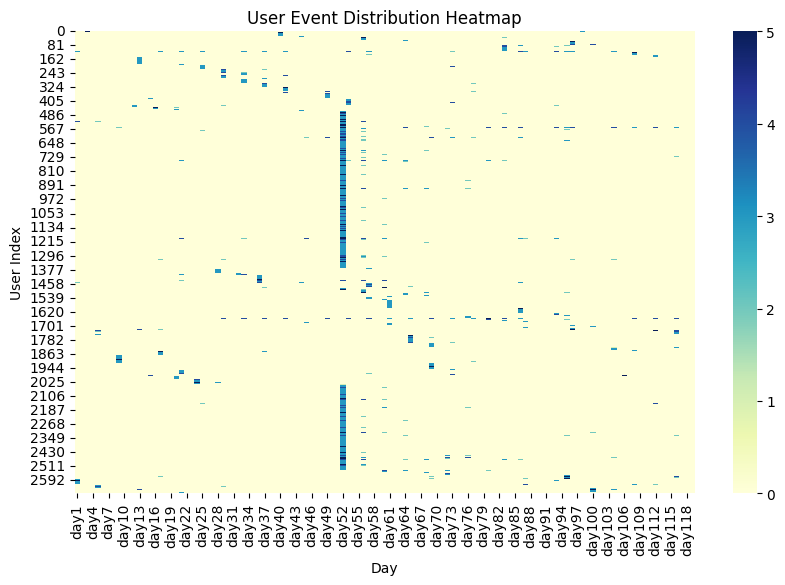

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 假设 df985 已经包含了 day1, day2 等列
day_columns = [col for col in df985.columns if col.startswith('day')]

# 计算每个用户在每天的事件数量
heatmap_data = df985[day_columns].applymap(len)

# 绘制热力图
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, cmap='YlGnBu')
plt.title('User Event Distribution Heatmap')
plt.xlabel('Day')
plt.ylabel('User Index')
plt.show()


<Figure size 1000x600 with 0 Axes>

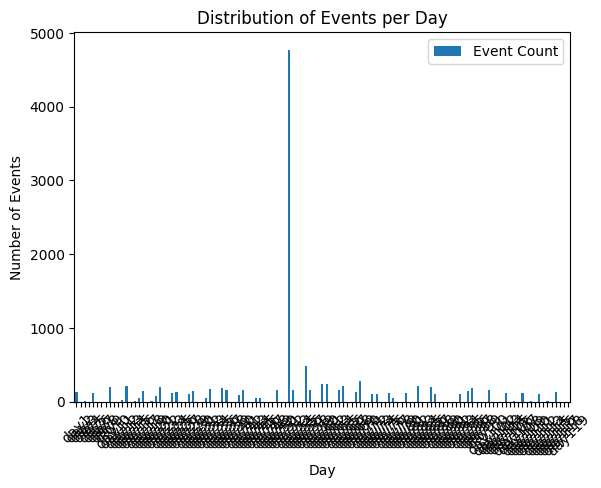

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设 df985 已经包含了 day1, day2 等列
day_columns = [col for col in df985.columns if col.startswith('day')]

# 统计每天的事件总数
event_counts = {}
for day in day_columns:
    total_events = sum([len(events) for events in df985[day]])
    event_counts[day] = total_events

# 转换为 DataFrame 方便绘图
count_df = pd.DataFrame.from_dict(event_counts, orient='index', columns=['Event Count'])

# 绘制柱状图
plt.figure(figsize=(10, 6))
count_df.plot(kind='bar')
plt.title('Distribution of Events per Day')
plt.xlabel('Day')
plt.ylabel('Number of Events')
plt.xticks(rotation=45)
plt.show()

